In [1]:
SOS_token = 0
EOS_token = 1
UNK = 3

In [2]:
EMBEDDING_SIZE = 128
HIDDEN_SIZE = 256
VOC_SIZE = 50000 #vocab.n_words#50000 #for both source and target
OUTPUT_SIZE = VOC_SIZE #10 # ?? 
BASELINE_VOC_SIZE = VOC_SIZE
MAX_LENGTH = 400

In [3]:
import json
import random

def loadDataset(path,limit=100000000000):
    print("Loading dataset...")
    dataset = list()
    i = 0
    for line in open(path, 'r'):
        all_data = json.loads(line)
        for data in all_data:
            if i <limit:
                dataset.append(data)
                i += 1
            else:
                break
    print("Loaded %d pieces of data"%len(dataset))
    return dataset


In [4]:
path_dev = "data/msmarco_2wellformed/dev_v2.0_well_formed.json"
path_train = "data/msmarco_2wellformed/train_v2.0_well_formed.json"
path_eval = "data/msmarco_2wellformed/evalpublicwellformed.json"
dataset_dev = loadDataset(path_dev)
dataset_train = loadDataset(path_train)
dataset_eval = loadDataset(path_eval)

Loading dataset...
Loaded 14261 pieces of data
Loading dataset...
Loaded 114091 pieces of data
Loading dataset...
Loaded 3 pieces of data


In [5]:
for i in range(6):
    print('')
    x = random.choice(dataset_train)
    print(x['query'])
    print(x['wellFormedAnswers'][0])


what are the four houses at hogwarts school of witchcraft and wizardry
The four houses at Hogwarts School of Witchcraft and Wizardry are Godric Gryffindor, Helga Hufflepuff, Rowena Ravenclaw and Salazar Slytherin.

what forms does an independent contractor need to fill out
An independent contractor needs to fill out IRS Form W-9.

where is porto alegre
Porto Alegre is in Brazil.

what is the first established state in us
Delaware is the first established state in United States.

what is true about atp molecule
Adenosine Tri Phosphate is a molecule with a lot of chemical energy.

average time for finishing london marathon
The average time for the finishing London Marathon is 4 hours, 6 minutes and 8 seconds.


In [6]:
import re

def insertCharIfSeq(sentence1,c,seq):
    i = 0
    indexes = [m.start() for m in re.finditer(seq, sentence1)]
    for index in indexes:
        sentence1 = sentence1[:index+i] + c + sentence1[index+i:]
        i += 1
    return sentence1

def processContractions(sentence1):
    sentence1 = insertCharIfSeq(sentence1," ","'s")
    sentence1 = insertCharIfSeq(sentence1," ","'m")
    sentence1 = insertCharIfSeq(sentence1," ","'ll")
    sentence1 = insertCharIfSeq(sentence1," ","'ve")
    sentence1 = insertCharIfSeq(sentence1," ","'re")
    sentence1 = insertCharIfSeq(sentence1," ","'d")
    return sentence1


def processNegatives(sentence1):
    i = 0
    indexes = [m.start() for m in re.finditer("can't", sentence1)]
    for index in indexes:
        sentence1 = sentence1[:index+i+3] + sentence1[index+i+2:]
        i += 1
    return insertCharIfSeq(sentence1," ","n't")

## WHAT TO DO WITH HYPHENS ??

def tokenizeSentence(sentence1):
#     processFinalPeriod(sentence1)
    sentence1 = processContractions(sentence1)
    sentence1 = processNegatives(sentence1)
    s = sentence1.lower()
    s = re.sub('''([.,!"?$;:/#`()])''', r' \1 ', s)
    s = re.sub('\s{2,}', ' ', s)
    s = s.split()
#     s = processHyphenIfUnknownWords(s,glove)
#     s.append('</s>')
#     s = ['<s>'] + s
    return s

def testTokenizeSentence():
    sentence1 = "I can't open the door because the 30-year old/blond-hair guy doesn't want to let me in. He's mean, isn't he? I can't go in! There's no other way!"
    words = tokenizeSentence(sentence1)
    print(words)
    
testTokenizeSentence()

['i', 'can', "n't", 'open', 'the', 'door', 'because', 'the', '30-year', 'old', '/', 'blond-hair', 'guy', 'does', "n't", 'want', 'to', 'let', 'me', 'in', '.', 'he', "'s", 'mean', ',', 'is', "n't", 'he', '?', 'i', 'can', "n't", 'go', 'in', '!', 'there', "'s", 'no', 'other', 'way', '!']


In [8]:
class Vocab:
    def __init__(self,voc_size=VOC_SIZE):
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS", 2: "UNK"}
        self.wordsOrderedByFreq = list()
        self.word2count["UNK"] = 0
        self.n_words = 3
        self.voc_size = voc_size
        
    def addSentence(self, sentence):
        for word in sentence:
            self.addWord(word)
            
    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
#             self.index2word[self.n_words] = word
#             self.n_words += 1
        else:
            self.word2count[word] += 1
            
    def buildVocabulary(self):
        # sort words by frequencies
        self.wordsOrderedByFreq = list(reversed(sorted(self.word2count, key=lambda key: self.word2count[key])))
        # get voc_size th element in list (= last word in vocab)
        last_word = self.wordsOrderedByFreq[self.voc_size]
        # get frequency of last word
        freq = self.word2count[last_word]
        print("Last word in vocabulary will be %s with a frequency of appearance of %d"%(last_word,freq))
        for i in range(self.voc_size):
            word = self.wordsOrderedByFreq[i]
            self.word2index[word] = self.n_words
            self.index2word[self.n_words] = word
            self.n_words += 1
        for j in range(self.voc_size,len(self.wordsOrderedByFreq)):
            self.word2index[word] = 2
            self.n_words += 1
            self.word2count['UNK'] += 1
        print("Vocabulary (size %d) is built. The firsts words are:"%self.voc_size)
        for k in range(2,7):
            word = self.index2word[k]
            print("%s (appeared %d times)"%(word,self.word2count[word]))

In [9]:
import math

vocab = Vocab()

def tokenizeDataset(dataset):
    tokenized_dataset = list()
    len_dataset = len(dataset)
    print_every = math.floor(len_dataset / 10)
    print('Tokenizing dataset...')
    for i, data in enumerate(dataset):
        tokenized_data = dict()
        tokenized_data['answers'] = list()
        tokenized_data['wellFormedAnswers'] = list()
        tokenized_data['passages'] = list()
        for answer in data['answers']:
            t = tokenizeSentence(answer)
            tokenized_data['answers'].append(t)
            vocab.addSentence(t)
        for wf_answer in data['wellFormedAnswers']:
            t = tokenizeSentence(wf_answer)
            tokenized_data['wellFormedAnswers'].append(t)
            vocab.addSentence(t)
        for passage in data['passages']:
            t = tokenizeSentence(passage['passage_text'])
            tokenized_data['passages'].append(t)
            vocab.addSentence(t)
        if i>0 and i%print_every == 0:
            print('... %d%%'%(i/print_every*10),end="\r")
        tokenized_dataset.append(tokenized_data)
            
    print('Number of different words: %d'%len(vocab.word2count))
    
    return tokenized_dataset

dataset_train_tokenized = tokenizeDataset(dataset_train)

Tokenizing dataset...
Number of different words: 664062


In [9]:
vocab.buildVocabulary()

Last word in vocabulary will be pg&e with a frequency of appearance of 32
Vocabulary (size 50000) is built. The firsts words are:
UNK (appeared 614062 times)
. (appeared 4992479 times)
the (appeared 4013086 times)
, (appeared 3710445 times)
of (appeared 2182732 times)


In [11]:
import torch
from torch.autograd import Variable

def indexesFromSentence(sentence): # sentence is a list of tokens
    return [vocab.word2index[word] for word in sentence]
        
def variableFromSentence(sentence):
    indexes = indexesFromSentence(sentence)
    indexes.append(EOS_token)
    return Variable(torch.LongTensor(indexes).view(-1,1))
                    
def variablesFromPair(pair):
    input_var = variableFromSentence(pair[0])
    target_var = variableFromSentence(pair[1])
    return input_var, target_var
        
example = random.choice(dataset_train_tokenized)
# print(example['passages'])
input_var = [item for sublist in example['passages'] for item in sublist]
input_var = list(input_var[:400])
input_var = variableFromSentence(input_var)
print(input_var.size())
target_var = example['wellFormedAnswers'][0]
target_var = variableFromSentence(target_var)
print(target_var.size())

torch.Size([401, 1])
torch.Size([28, 1])


In [12]:
import torch.nn as nn
import torch.nn.functional as F


class EncoderLSTM(nn.Module):
    
    def __init__(self,embedding_size=EMBEDDING_SIZE,hidden_size=HIDDEN_SIZE,voc_size=VOC_SIZE):
        super(EncoderLSTM,self).__init__()
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.voc_size = voc_size
        
        self.embedding = nn.Embedding(voc_size, embedding_size)
        self.bilstm = nn.LSTM(embedding_size, hidden_size, num_layers =1, bidirectional=True)
                
    def initHidden(self):
        return (Variable(torch.zeros(2, 1, self.hidden_size)), # 2 because bidirectional
                Variable(torch.zeros(2, 1, self.hidden_size)))
        
    def forward(self, input, hidden):
#         print(input)
        embedded = self.embedding(input).view(1,1,-1)
        output, hidden = self.bilstm(embedded, hidden)
        return hidden
        
encoder = EncoderLSTM()
input_length = len(input_var)
encoder_hidden = encoder.initHidden()        
h = Variable(torch.zeros(input_length, encoder.hidden_size*2))        
for ei in range(input_length):
    encoder_hidden = encoder(input_var[ei],encoder_hidden)
    h[ei] = torch.cat((encoder_hidden[0][0],encoder_hidden[1][0]),1)
print(input_var.size())
print(h.size())

torch.Size([401, 1])
torch.Size([401, 512])


## Decoder

In [13]:
class AttnDecoderLSTM(nn.Module):
    
    def __init__(self,embedding_size=EMBEDDING_SIZE,hidden_size=HIDDEN_SIZE,output_size=OUTPUT_SIZE,
                 voc_size=VOC_SIZE,max_length=MAX_LENGTH):
        super(AttnDecoderLSTM,self).__init__()
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.voc_size = voc_size
        
        self.embedding = nn.Embedding(voc_size, embedding_size)
        self.decoder_bilstm = nn.LSTM(self.embedding_size,self.hidden_size, num_layers=1, bidirectional = True)
        self.attn_Ws = nn.Linear(hidden_size *2, hidden_size) #?
        self.attn_Wh = nn.Linear(hidden_size *2, hidden_size) #?
        self.attn_v = nn.Linear(hidden_size, 1)
        self.lin_V1 = nn.Linear(hidden_size*4, hidden_size)
        self.lin_V2 = nn.Linear(hidden_size, output_size)
        self.test = nn.Linear(hidden_size*2,output_size)
        
    def initHidden(self):
        return (Variable(torch.zeros(2, 1, self.hidden_size)), # 2 because bidirectional
                Variable(torch.zeros(2, 1, self.hidden_size)))
        
    def forward_rec(self,input,hidden):
        emb = self.embedding(input).view(1,1,-1)
        output, hidden = self.decoder_bilstm(emb,hidden)
        return output, hidden
    

    def forward(self, target_var, h):
        input_length = h.size()[0]
        target_length = len(target_var)
        hidden = self.initHidden()        
        outputs = Variable(torch.zeros(target_length, self.hidden_size*2))  
        s = Variable(torch.zeros(target_length,self.hidden_size*2))
        input = Variable(torch.LongTensor([[SOS_token]]))    
        
        for di in range(target_length):
            output, hidden = self.forward_rec(input, hidden)
            outputs[di] = output[0]
            s[di] = torch.cat((hidden[0][0],hidden[1][0]),1)
            input = target_var[di]
        
        # attention distribution
        Wh = self.attn_Wh(h) # dim: # of words in input , 256
        Ws = self.attn_Ws(s) # dim: # of words in target , 256
        Wh_Ws_d = Variable(torch.zeros(target_length,input_length,256)) # dim: # of words in target, # of words in input , 256 
        for i in range(target_length):
            Wh_Ws_d[i] = torch.add(Wh,Ws[0])
        Wh_Ws_d = F.tanh(Wh_Ws_d) # dim: # of words in target, # of words in input , 256 
        e = self.attn_v(Wh_Ws_d) # dim: # of words in target, # of words in input , 1 
        e = e.permute(0,2,1) # dim: # of words in target, 1, # of words in input 
        a = F.softmax(e, dim=2) # dim: # of words in target, 1, # of words in input 
        h_extended = torch.add(Variable(torch.zeros(target_length,input_length,self.hidden_size*2)),h)
        hstar = torch.bmm(a,h_extended) # dim: #of target words, 1, 512
        # vocabulary distribution
        v1 = torch.cat((s.unsqueeze(1),hstar),dim=2) # dim: #of target words, 1, 1024
        v1 = self.lin_V1(v1) # dim: #of target words, 1, 256
        v2 = self.lin_V2(v1) # dim: #of target words, 1, vocabulary size
        Pvocab = F.softmax(v2,dim=2) # dim: #of target words, 1, vocabulary size
        x = self.test(s).unsqueeze(1)
#         print(s.size())
        Pvocab = F.log_softmax(x,2)
        
        return Pvocab, outputs    
      
decoder2 = AttnDecoderLSTM()
loss = 0
Pvocab, outputs = decoder2(target_var,h)
criterion = nn.NLLLoss()
for i in range(len(outputs)):
    loss += criterion(Pvocab[i],target_var[i])
print (loss/len(target_var))

Variable containing:
 11.0971
[torch.FloatTensor of size 1]



In [14]:
import torch.optim as optim

In [15]:
import time, math
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s/60)
    s -= m*60
    return '%dm %ds' %(m,s)

In [16]:
import torch.optim as optim

def trainingStep(input_var, target_var, encoder, decoder, encoder_optimizer, decoder_optimizer, 
          criterion, max_length=MAX_LENGTH, debug=False):
    
    if debug:
        print('Starting encoding')
        
    input_length = len(input_var)
    encoder_hidden = encoder.initHidden()        
    h = Variable(torch.zeros(input_length, encoder.hidden_size*2))        
    for ei in range(input_length):
        encoder_hidden = encoder(input_var[ei],encoder_hidden)
        h[ei] = torch.cat((encoder_hidden[0][0],encoder_hidden[1][0]),1)

    target_length = len(target_var)    
    if debug:
        print('Starting decoding, target_length = %d'%target_length)
    
    Pvocab, outputs = decoder(target_var,h)
    loss = 0
    for i in range(target_length):
        loss += criterion(Pvocab[i],target_var[i])        
        
    if debug:
        start = time.time()
        print('Starting backprop')
    loss.backward()    
    if debug:
        print('Done with backprop, took %s'%timeSince(start))
        
    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.data[0] / target_length


encoder_opt = optim.SGD(encoder.parameters(), lr=0.01)
decoder_opt = optim.SGD(encoder.parameters(), lr=0.01)
decoder = AttnDecoderLSTM()
loss = trainingStep(input_var,target_var,encoder,decoder,encoder_opt,decoder_opt,nn.NLLLoss(),debug=True)
print(loss)

Starting encoding
Starting decoding, target_length = 28
Starting backprop
Done with backprop, took 0m 1s
11.445977347237724


In [26]:
plot_losses = []

def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    print_loss_total = 0 # reset every print_every
    plot_loss_total = 0 # reset every plot_every
    
    encoder_optimizer = optim.SGD(encoder.parameters(), lr = learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr = learning_rate)
    training = [random.choice(dataset_train_tokenized) for i in range(n_iters)]
    criterion = nn.NLLLoss()
    
    for iter in range(1, n_iters + 1):
        example = training[iter]
        input_variable = [item for sublist in example['passages'] for item in sublist]
        input_variable = list(input_variable[:400])
        input_variable = variableFromSentence(input_variable)
        target_variable = example['wellFormedAnswers'][0]
        target_variable = variableFromSentence(target_variable)

        loss = trainingStep(input_variable, target_variable, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss
        

        if iter % print_every == 0:
            print(example['wellFormedAnswers'][0])
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
            
    showPlot(plot_losses)

In [30]:
encoder1 = EncoderLSTM()
attn_decoder1 = AttnDecoderLSTM()

all_losses = trainIters(encoder1, attn_decoder1, 7500, learning_rate=0.001, print_every=50, plot_every = 1)

['the', 'fastest', 'moves', 'seismic', 'wave', 'is', 'p', 'wave', 'or', 'primary', 'wave', '.']
1m 28s (50 0%) 9.9580
['a', 'scramjet', 'or', 'supersonic', 'combusting', 'ramjet', 'is', 'a', 'variant', 'of', 'a', 'ramjet', 'airbreathing', 'jet', 'engine', 'in', 'which', 'combustion', 'takes', 'place', 'in', 'supersonic', 'airflow', '.']
2m 50s (100 1%) 27.9004
['the', 'average', 'yacht', 'captain', 'salary', 'is', '$', '150', ',', '000', 'a', 'year', '.']
4m 10s (150 2%) 15.9316
['the', 'max', 'time', 'before', 'you', 'write', 'thank', 'you', 'notes', 'after', 'a', 'funeral', 'is', 'within', 'two', 'to', 'three', 'weeks', '.']
5m 24s (200 2%) 38.2521
['the', 'causes', 'of', 'pain', 'and', 'swelling', 'of', 'taste', 'buds', 'are', 'mild', 'burn', 'from', 'hot', 'foods', ',', 'spicy', 'foods', ',', 'sensitivity', 'or', 'allergic', 'reaction', 'to', 'spices', 'and', 'other', 'foods', 'and', 'liquids', 'ingested', 'to', 'a', 'number', 'of', 'medical', 'conditions', '.']
6m 44s (250 3%) 96.

KeyboardInterrupt: 

In [28]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    plt.plot(points)
    plt.show()

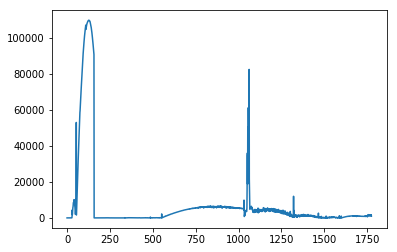

In [31]:
showPlot(plot_losses)